<a href="https://colab.research.google.com/github/vittorio-pepe/Northwestern_422/blob/master/MSDS_462_Week1_Fashion_MNIST_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSDS 462 - Week 1 Assignment


## Kaggle connection, gdrive and data download



In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!ls -l /content/gdrive/My\ Drive

total 1532
drwx------ 2 root root    4096 Sep 18 14:11  462
drwx------ 2 root root    4096 Sep 20 16:48 'Colab Notebooks'
-rw------- 1 root root 1560010 Aug 30  2019 'Getting started.pdf'


In [3]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp /content/gdrive/My\ Drive/462/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
#/content is the root folder of Google Colab
# remove the files that you don't need "rm fashion-mnist_test.csv"
!kaggle datasets download -d zalando-research/fashionmnist
!ls -al /content
!unzip /content/fashionmnist.zip

 86% 59.0M/68.8M [00:01<00:00, 26.3MB/s]
100% 68.8M/68.8M [00:01<00:00, 44.5MB/s]
total 70448
drwxr-xr-x 1 root root     4096 Sep 20 18:53 .
drwxr-xr-x 1 root root     4096 Sep 20 18:50 ..
drwxr-xr-x 1 root root     4096 Sep 16 16:29 .config
-rw-r--r-- 1 root root 72114846 Sep 20 18:53 fashionmnist.zip
drwx------ 4 root root     4096 Sep 20 18:53 gdrive
drwxr-xr-x 1 root root     4096 Sep 16 16:29 sample_data
Archive:  /content/fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


## Import Packages

In [5]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from itertools import product

## Dataframe creation, EDA and formatting

In [11]:
# set sizes
image_rows = 28
image_cols = 28
batch_size = 64
image_shape = (image_rows, image_cols, 1)

# data
train =pd.read_csv( "/content/fashion-mnist_train.csv")
test = pd.read_csv("/content/fashion-mnist_test.csv")

train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


In [7]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,14.488767,32.830583,45.731017,52.064083,50.80245,50.459150,53.796217,51.396233,40.432733,26.083333,10.420583,4.079750,1.938183,1.177650,0.857983,0.461133,0.244300,0.092667,0.018333,0.006400,0.020617,0.098967,0.357200,0.767217,2.104583,7.331483,17.472317,32.009017,52.814583,79.349917,...,92.470233,90.523350,79.255767,62.576500,45.753283,43.970183,47.772400,38.841583,22.306933,9.280517,3.955417,0.631000,0.024633,0.218117,1.027250,4.352033,12.568183,20.847967,21.076467,17.152267,22.114933,30.559350,41.743617,51.506583,52.60855,46.479783,42.612733,45.309733,50.162100,46.438617,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,38.334549,57.633860,65.964300,68.603587,67.86885,67.370188,69.467796,67.912739,62.639596,51.818389,32.591095,20.118496,13.953210,10.718718,9.256114,6.768024,4.953103,2.850576,1.232175,0.548966,1.184869,2.912779,6.523878,9.702476,15.977721,30.056073,47.953585,65.625544,82.122567,95.340204,...,100.912013,99.731484,95.172029,88.844198,78.434831,76.970849,83.212136,74.477031,55.983447,37.937984,24.953295,8.146274,0.968474,4.444904,10.030021,20.912278,36.920905,48.909477,48.263137,42.173000,48.241135,54.902062,61.963606,68.331468,69.76041,67.476669,66.267004,66.737520,68.705817,65.944847,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2

<function matplotlib.pyplot.show>

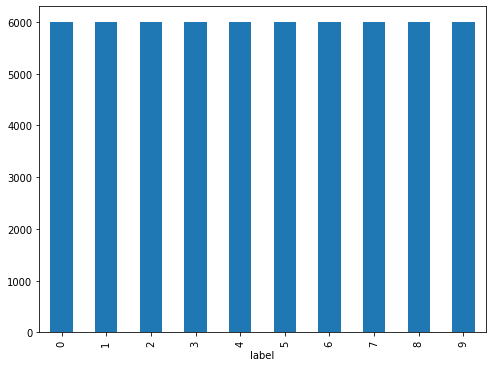

In [8]:
# class balance 
fig = plt.figure(figsize=(8,6))
train.groupby('label').pixel1.count().plot.bar(ylim=0)
plt.show

In [12]:
# standardize/normalize dataset
train_data = np.array(train, dtype = 'float32')
test_data = np.array(test, dtype = 'float32')

X_train = train_data[:, 1:]/255
y_train = train_data[:,0]
X_test = test_data[:, 1:]/255
y_test = test_data[:,0]

In [13]:
# splitting the train data to validations
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.05, random_state = 1234, shuffle = True)

# convert the target to the categorical variables
y_train = to_categorical(y_train, num_classes = 10)
y_val = to_categorical(y_val, num_classes = 10) 
y_test = to_categorical(y_test, num_classes = 10)


# reshape
X_train = X_train.reshape(-1,28,28,1)
X_val = X_val.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

print(X_train.shape, X_val.shape, X_test.shape,)

(57000, 28, 28, 1) (3000, 28, 28, 1) (10000, 28, 28, 1)


## Data Augumentation

In [14]:
# data augmentation 
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    vertical_flip=True)

## Model Definition


In [15]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                   strides = (1,1), padding = 'Same',
                   input_shape = image_shape, activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),
                   strides = (1,1), padding = 'Same',
                   input_shape = image_shape, activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (3,3),
                   strides = (1,1), padding = 'Same',
                   activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),
                   strides = (1,1), padding = 'Same',
                   activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 256, kernel_size = (3,3),
                   strides = (1,1), padding = 'Same',
                   activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(units=512, use_bias = True, activation = 'relu'))
model.add(Dense(units=10, use_bias = True, activation = 'softmax'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])



In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0

## Callbacks

In [17]:
estop =EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5)

lr = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

round(model.optimizer.lr.numpy(), 5)


0.001

## Training the model

In [18]:
epochs = 15

history = model.fit(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_val, y_val), callbacks = [lr])

Epoch 1/15
891/891 [==============================] - 18s 20ms/step - loss: 0.6886 - accuracy: 0.7688 - val_loss: 0.4236 - val_accuracy: 0.8487
Epoch 2/15
891/891 [==============================] - 17s 20ms/step - loss: 0.4236 - accuracy: 0.8448 - val_loss: 0.5017 - val_accuracy: 0.7957
Epoch 3/15
891/891 [==============================] - 18s 20ms/step - loss: 0.3671 - accuracy: 0.8661 - val_loss: 0.3882 - val_accuracy: 0.8590
Epoch 4/15
891/891 [==============================] - 17s 20ms/step - loss: 0.3387 - accuracy: 0.8747 - val_loss: 0.3276 - val_accuracy: 0.8790
Epoch 5/15
891/891 [==============================] - 18s 20ms/step - loss: 0.3169 - accuracy: 0.8839 - val_loss: 0.3014 - val_accuracy: 0.8907
Epoch 6/15
891/891 [==============================] - 18s 20ms/step - loss: 0.2993 - accuracy: 0.8901 - val_loss: 0.3186 - val_accuracy: 0.8770
Epoch 7/15
891/891 [==============================] - 18s 20ms/step - loss: 0.2877 - accuracy: 0.8940 - val_loss: 0.3218 - val_accuracy:

In [ ]:
round(model.optimizer.lr.numpy(), 5)

0.00049

## Evaluating the model

In [19]:
metrics = list(history.history.keys())
loss_values = history.history[metrics[2]]
val_loss_values = history.history[metrics[0]]
acc_values = history.history[metrics[3]]
val_acc_values = history.history[metrics[1]]
print("final validation loss function is", val_loss_values[-1])
print("final validation accuracy is", val_acc_values[-1])

final validation loss function is 0.2159382849931717
final validation accuracy is 0.9191228151321411


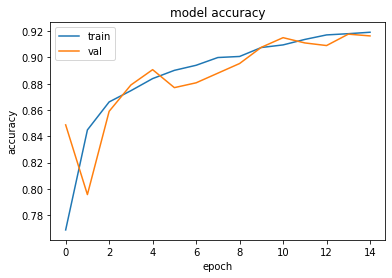

In [20]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')


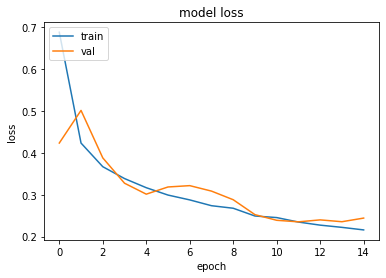

In [21]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

## Testing on test dataset

In [22]:
print('Evaluating against test data...', flush=True)
loss, acc = model.evaluate(X_test, y_test)
print('  - Test data: loss %.3f - acc %.3f' % (loss, acc))

Evaluating against test data...
313/313 [==============================] - 1s 4ms/step - loss: 0.2279 - accuracy: 0.9240
  - Test data: loss 0.228 - acc 0.924


## Confusion Matrix

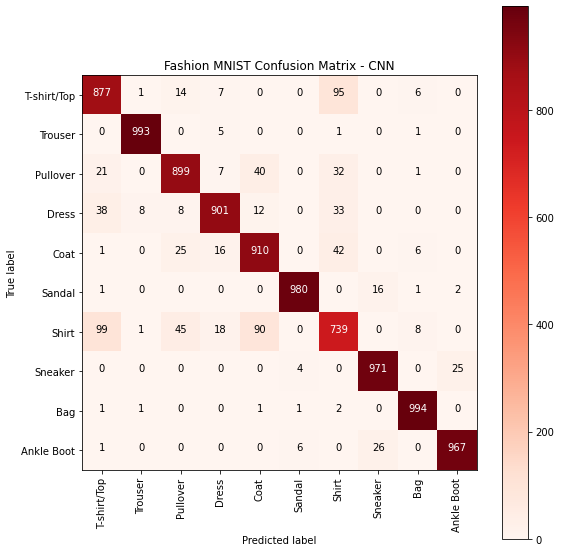

In [ ]:

classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

#Create Multiclass Confusion Matrix

preds = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(preds,axis=1))

plt.figure(figsize=(8,8))
plt.imshow(cm,cmap=plt.cm.Reds)
plt.title('Fashion MNIST Confusion Matrix - CNN')
plt.colorbar()
plt.xticks(np.arange(10), classes, rotation=90)
plt.yticks(np.arange(10), classes)

for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
    horizontalalignment="center",
    color="white" if cm[i, j] > 500 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Picture with labels test dataset after classification

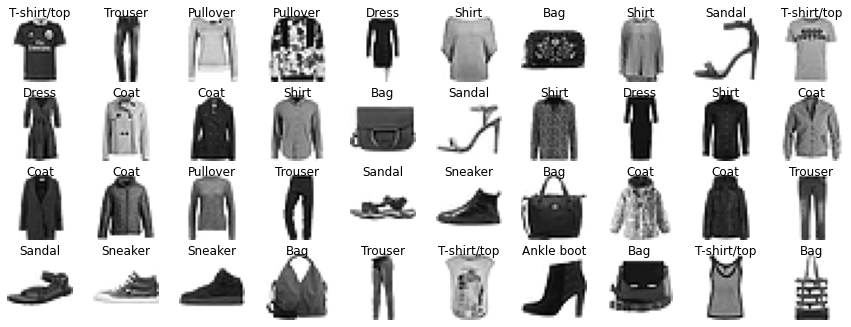

In [ ]:
results = np.zeros((X_test.shape[0],10))
results = results + model.predict(X_test)
results = np.argmax(results, axis = 1)
results = pd.Series(results, name = "Label")

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress','Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(15,6))
for i in range(40):
  plt.subplot(4, 10, i+1)
  plt.imshow(X_test[i].reshape((28,28)), cmap =plt.cm.binary)
  plt.title(class_names[results[i]], y=0.9)
  plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()